## import data and libraries

In [5]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import math

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

device = "cuda" if torch.cuda.is_available() else "cpu"

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU device: NVIDIA GeForce RTX 3050 Ti Laptop GPU
GPU memory: 4.3 GB


In [6]:
class ModelNetCustomDataset(Dataset):
    def __init__(self, train: bool, classes=None, debug=True):
        self.debug = debug
        
        if train:
            x = torch.load("../data/ModelNet_subset/train_x.pt", weights_only=True)
            y = torch.load("../data/ModelNet_subset/train_y.pt", weights_only=True)
        else:
            x = torch.load("../data/ModelNet_subset/test_x.pt", weights_only=True)
            y = torch.load("../data/ModelNet_subset/test_y.pt", weights_only=True)

        # Load class names
        raw_dir = r"C:\Users\snevi\OneDrive\Documents\coding\AI\deep_learning\data\ModelNet\raw"
        self.class_names = sorted([
            name for name in os.listdir(raw_dir)
            if os.path.isdir(os.path.join(raw_dir, name))
        ])

        # Initialize mappings
        self.class_mapping = None
        self.reverse_mapping = None
        self.original_classes = classes

        if self.debug:
            print(f"Original data shapes: x={x.shape}, y={y.shape}")
            print(f"Original label range: [{y.min()}, {y.max()}]")
            print(f"Classes to filter: {classes}")

        # Filter classes FIRST, then standardize the filtered data
        if classes is not None:
            x, y = self.filter_classes(x, y, classes)
            
            if self.debug:
                print(f"After filtering: x={x.shape}, y={y.shape}")
                print(f"Filtered label range: [{y.min()}, {y.max()}]")

            # Create mapping from original class IDs to new contiguous IDs
            self.class_mapping = {original_id: new_id for new_id, original_id in enumerate(sorted(classes))}
            self.reverse_mapping = {new_id: original_id for original_id, new_id in self.class_mapping.items()}
            
            if self.debug:
                print(f"Class mapping: {self.class_mapping}")
            
            # Remap class IDs to be contiguous [0, 1, 2, ..., len(classes)-1]
            y = self.remap_classes(y)
            
            if self.debug:
                print(f"After remapping: label range [{y.min()}, {y.max()}]")
                print(f"Expected range: [0, {len(classes)-1}]")

        # Apply standardization to the (potentially filtered) data
        self.x = self.standardise(x)
        self.y = y
        
        if self.debug:
            print(f"Final dataset: x={self.x.shape}, y={self.y.shape}")
            print(f"Final label range: [{self.y.min()}, {self.y.max()}]")
        
    def remap_classes(self, y):
        """Remap original class IDs to contiguous range [0, 1, 2, ...]"""
        y_remapped = torch.zeros_like(y)
        for i in range(len(y)):
            original_class = y[i].item()
            if original_class not in self.class_mapping:
                raise ValueError(f"Class {original_class} not found in mapping {self.class_mapping}")
            new_class = self.class_mapping[original_class]
            y_remapped[i] = new_class
        return y_remapped

    def standardise(self, x):
        standardised_data = torch.zeros_like(x)
        for i in range(x.shape[0]):
            obj = x[i]
            mean_x = obj.mean(dim=0)
            std_x = obj.std()
            standardised_data[i] = (obj - mean_x) / (std_x + 1e-8)
        return standardised_data

    def filter_classes(self, x, y, classes):
        indices_to_keep = []
        for idx in range(len(y)):
            if y[idx].item() in classes:
                indices_to_keep.append(idx)
        
        if len(indices_to_keep) == 0:
            raise ValueError(f"No samples found for classes {classes}")
        
        x_selected = torch.index_select(x, dim=0, index=torch.tensor(indices_to_keep))
        y_selected = torch.index_select(y, dim=0, index=torch.tensor(indices_to_keep))
        return x_selected, y_selected

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        point_cloud = self.x[idx]
        class_id = self.y[idx]

        # Get original class name using reverse mapping
        if self.reverse_mapping is not None:
            original_class_id = self.reverse_mapping[class_id.item()]
            label = self.class_names[original_class_id]
        else:
            label = self.class_names[class_id.item()]
        
        return point_cloud, class_id, label

## steps

In [7]:
def accuracy_fn(y_pred,y_true):
    """
    Calculate accuracy of predictions
    Args:
        y_pred: Predictions from model (logits)
        y_true: True labels
    Returns:
        Accuracy as a percentage
    """
    # Get predicted class indices by taking argmax along the last dimension
    y_pred_indices = torch.argmax(y_pred, dim=1)
    
    # Compare with true labels and calculate accuracy
    correct = (y_pred_indices == y_true).sum().item()
    total = y_true.size(0)
    
    return correct / total * 100  # Return accuracy as percentage

In [ ]:
def train_step(
        model: nn.Module,
        data_loader: DataLoader,
        loss_fn: nn.Module,
        optimiser: torch.optim.Optimizer,
        accuracy_fn,
        device: torch.device = device,
        verbose: bool=True):

    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    
    #print(f"training loop on {device}...")
    
    for batch, (X, y, names) in enumerate(data_loader):
        
        try:
            # Move data to device
            X, y = X.to(device), y.to(device)
            
            # Fix label shape
            if y.dim() > 1:
                y = y.squeeze()
            y=y.long()

            # Forward pass
            y_pred = model(X)
            
            # Loss and accuracy
            loss = loss_fn(y_pred, y)
            acc = accuracy_fn(y_pred, y)
            
            train_loss += loss.item()
            train_acc += acc
            
            # Backward
            optimiser.zero_grad()
            loss.backward()
            
            # Update
            optimiser.step()
            
        except Exception as e:
            print(f"   Error in batch {batch + 1}: {e}")
            import traceback
            traceback.print_exc()
            break
    
    # Calculate averages
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    if verbose == True:
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc


In [ ]:
def test_step(
        model: nn.Module,
        data_loader: DataLoader,
        loss_fn: nn.Module,
        accuracy_fn,
        device: torch.device = device,
        verbose: bool=True
):
        test_loss, test_acc = 0, 0
        model.to(device)
        model.eval()  # Set model to evaluation mode
        with torch.inference_mode():  # No gradients needed for inference
            try:
                for batch, (X, y, names) in enumerate(data_loader):
                    X, y = X.to(device), y.to(device)

                    if y.dim() > 1:
                        y = y.squeeze()  # Converts [64, 1] to [64]
                    y=y.long()
                    
                    y_pred = model(X)

                    loss = loss_fn(y_pred, y)
                    acc = accuracy_fn(y_pred, y)

                    test_loss += loss.item()
                    test_acc += acc

            except Exception as e:
                print(f"   Error in batch {batch + 1}: {e}")
                import traceback
                traceback.print_exc()

            # Average loss per batch per epoch
            test_loss /= len(data_loader)
            test_acc /= len(data_loader)
            if verbose == True:
                print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")
        return test_loss, test_acc

In [10]:
def train_model(model,epochs, verbose = True):
    train_accs,test_accs,train_losses,test_losses=[],[],[],[]
    loss_fn= nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Added weight decay for regularisation

    # Use tqdm only if verbose is True
    epoch_iterator = tqdm(range(epochs)) if verbose else range(epochs)
    
    for epoch in epoch_iterator:
        if verbose:
            print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Train step
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimiser=optimiser,
            accuracy_fn=accuracy_fn,
            device=device,
            verbose=verbose
        )
        
        # Test step
        test_loss, test_acc = test_step(
            model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device,
            verbose=verbose
        )
        
        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    if not verbose:
        print(f"Final: Train Acc: {train_accs[-1]:.2f}%, Test Acc: {test_accs[-1]:.2f}%")
    
    
    return train_accs, test_accs, train_losses, test_losses


In [11]:
def plot_acc_losses(
        model_name: str,
        train_accs: list,
        test_accs: list,
        train_losses: list,
        test_losses: list,
        epochs: int = 7
):
        f,(ax1,ax2)=plt.subplots(1,2)
        f.set_size_inches(15,5)
        ax1.plot(np.arange(1,epochs+1,1),test_accs,label="Test Accuracies")
        ax1.plot(np.arange(1,epochs+1,1),train_accs, label="Train Accuracies")
        ax1.set_title(f"{model_name} Accuracies")
        ax1.legend()
        ax1.set_ylabel("Accuracies (%)")
        ax1.set_xlabel("Epochs")

        ax2.plot(np.arange(1,epochs+1,1),test_losses, label="Test Losses")
        ax2.plot(np.arange(1,epochs+1,1),train_losses, label="Train Losses")
        ax2.set_title(f"{model_name} Losses")
        ax2.legend()
        ax2.set_ylabel("Losses")
        ax2.set_xlabel("Epochs")
    

## models

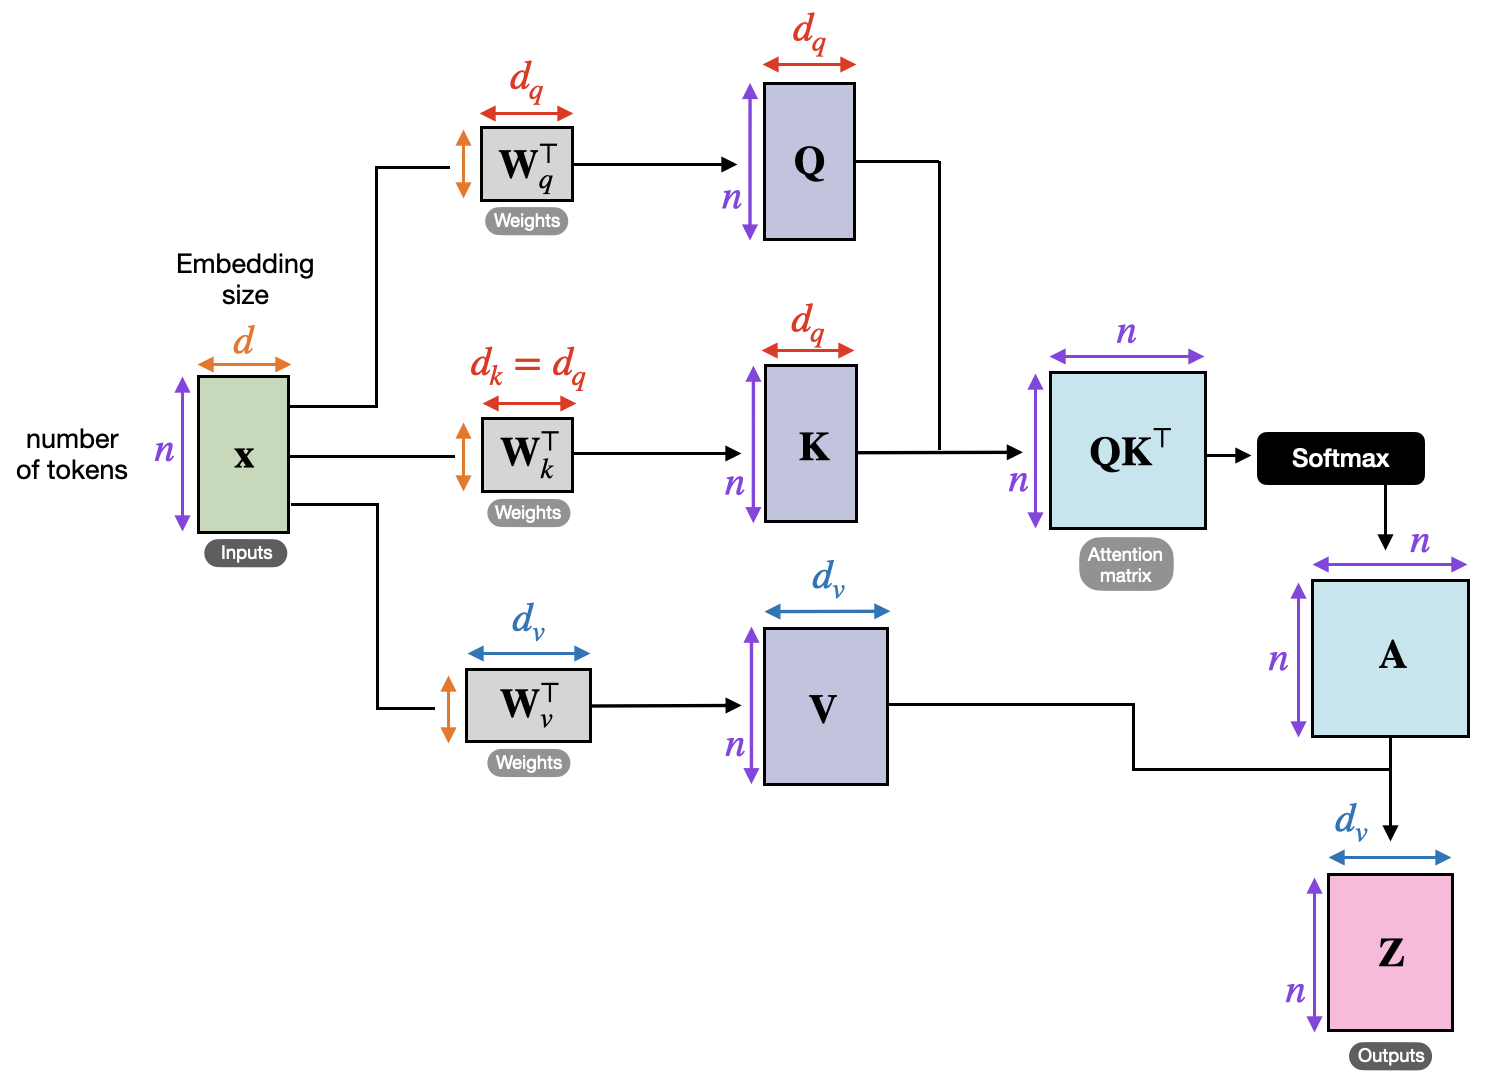

let $d_k = d_q = d_v = D$ to allow layers to stack

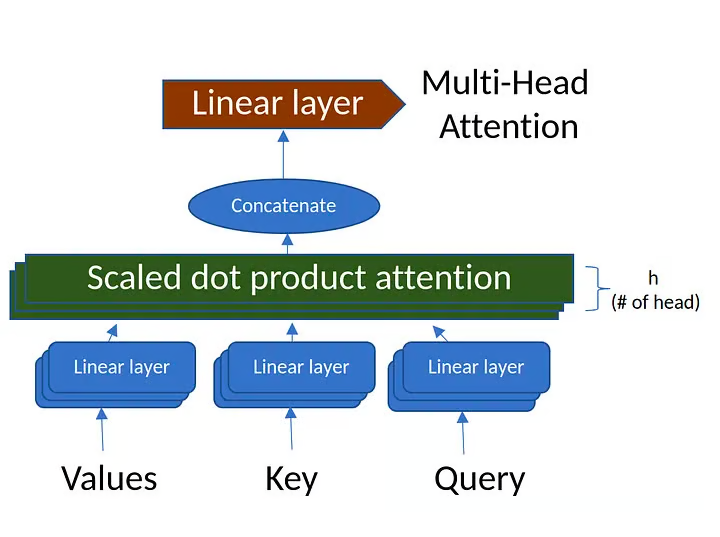

Instead of one head, use h heads with smaller per-head width $d_h=d_{model}/h$. Each head learns different relational subspaces as each head has its own $W_Q, ~ W_K, ~ W_V$ - can capture diverse patterns eg local vs global. Typically choose, $d_{model}=h~x~d_h, ~ d_k=d_v=d_h$. 
Concatenate head outputs and project back to $d_{model}$.

In [12]:
class MultiHeadAttention(nn.Module):
    """
    x: (B, N, D)
        N = num of features
        D = dim of model
    Returns: (B, N, D) where D = out_dim
    """
    def __init__(self,
            dim:int,
            num_heads:int,
            #p_drop: float = 0.0
        ):
        super().__init__()

        self.dim=dim #dim of input
        self.num_heads=num_heads
        
        self.d_k=dim//num_heads #D//h = Dimension of each head's key, query, and value

        self.W_q=nn.Linear(dim,dim) 
        self.W_k=nn.Linear(dim,dim)
        self.W_v=nn.Linear(dim,dim)

        self.W_y=nn.Linear(dim,dim) #output transformation

        # #dropout for attention probabilities - randomly zeroes fraction p and rescales rest by 1/(1-p) (Pytorch inverted dropout)
        # #encourages model not to rely on single sharp attention pattern to improve generalisation
        # self.attn_drop = nn.Dropout(p_drop)

        # #feature dropout on per-token features produced by attention - randomly zeros elements of output vectors
        # self.proj_drop = nn.Dropout(p_drop)

    def split_heads(self,x):
        batch,n,dim=x.size()
        x_split=x.reshape(batch,n,self.num_heads,self.d_k).transpose(-3,-2)
        #print('x ',x.shape)
        #print('x spl', x_split.shape)
        return x_split

    def combine_heads(self,x_split):
        batch,num_heads,n,d_k=x_split.size()
        # x_final = x_split.reshape(batch,n,self.dim).transpose(-2,-1)
        x_final = x_split.reshape(batch,n,self.dim)
        # print(f"x1 shape {x1.shape}")
        # x_final = x1.transpose(-2,-1)
        #print(f"x_final shape {x_final.shape}")
        return x_final

    def scaled_dot_product_attention(self,q_split,k_split,v_split):
        #calculate attention weights
        # k.T flips all dims, including batch -> only need to transpose last two dims
        # k:(B,N,D) -> k.T:(D,N,B)
        # (B,N,D) @ (B,D,N) -> (B,N,N)

        # #single head:
        # scores = (q @ k.transpose(-2, -1)) * self.scale  # (B, N, N)
        # attn = torch.softmax(scores, dim=-1)             # (B, N, N)
        # attn = self.attn_drop(attn)
        # y = attn @ v                                     # (B, N, D)
        # y = self.proj_drop(y)

        k_split_T = k_split.transpose(-2,-1)
        #print('k spl t ',k_split_T.shape)
        #print('q spl ', q_split.shape)  

        attn_scores = torch.matmul(q_split,k_split_T) / math.sqrt(self.d_k)
        attn_probs = torch.softmax(attn_scores,dim=-1)
        y_split = torch.matmul(attn_probs,v_split)
        #print(f"y_split shape {y_split.shape}")

        return y_split

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, N, E)
        q_split = self.split_heads(self.W_q(x))                     # (B, N, D) -> (B, h, N, D/h)
        k_split = self.split_heads(self.W_k(x))                     # (B, N, D) -> (B, h, N, D/h)
        v_split = self.split_heads(self.W_v(x))                     # (B, N, D) -> (B, h, N, D/h)

        y_split=self.scaled_dot_product_attention(q_split,k_split,v_split)
        y=self.W_y(self.combine_heads(y_split))

        return y

In [13]:
class MultiHeadClassifier(nn.Module):
    """
    attention classifier for point clouds.
    Input: (B, N, 3)

    -- attn(d_k,d_v,out_dim) --> (B,N,D)
    -- mean pooling --> (B,D)
    -- linear --> (B, num_classes)

    Output: (B, num_classes) logits
    """
    def __init__(self, 
            num_classes:int,
            embed_dim:int =64,
            num_heads:int=8,
            p_drop: float = 0.1):
        
        super().__init__()

        #takes each point's raw coords (x,y,z) and lifts them into richer feature space of size embed_dim
        #3 numbers too limited for attention to learn useful relations
        #small MLP creates more expressive per-point features


        self.embed=nn.Sequential(
            nn.Linear(3,embed_dim),
            nn.ReLU()
        )

        self.attn = MultiHeadAttention(
            dim=embed_dim,
            num_heads=num_heads
        #,p_drop=p_drop
        )

        #if ever switch back to mean-only, change the head to nn.Linear(out_dim, num_classes)
        self.head = nn.Linear(embed_dim, num_classes) 

    def forward(self, x):
        x=self.embed(x)         # (B, N, embed_dim)
        x=self.attn(x)            # (B, N, out_dim)

        #mean pool over points, averages over N points
        #symmetric reduction - permutation-invariant as reordering points does not change mean - important as point cloud is an unordered set
        #smooth, noise tolerant summary
        feat_mean = x.mean(dim=1)        # (B, D) 

        #max pool over points, takes max over N points
        #takes strongest activation per channel to pick out edge like features
        # feat_max = x.amax(dim=1)   # (B, out_dim)

        #global pooling - fuses smooth global trends and extremes -> gives small accuracy boost
        #feat = torch.cat([feat_mean,feat_max],dim=-1) # (B, 2*out_dim)

        #pooled feature goes through linear layer to produce class logits suitable for nn.CrossEntropyLoss
        logits = self.head(feat_mean)    # (B, num_classes)
        return logits


## test

In [14]:
#selected_classes = [0, 5, 6, 7, 8, 10, 19, 24, 26, 30, 32, 33, 34, 35, 37]
all_classes = [i for i in range(0,40)]
poor_classes = [24,39,1,21,36,12,23,3,10,15,11,38,29,13,27]
selected_classes = [i for i in all_classes if i not in poor_classes]
NUM_CLASSES = len(selected_classes)
train_dataset = ModelNetCustomDataset(train=True, classes=selected_classes, debug=False)
test_dataset = ModelNetCustomDataset(train=False, classes=selected_classes, debug=False)

BATCH_SIZE = 32
EPOCHS = 20
INPUT_SHAPE = (200, 3)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



In [15]:
# attention_model = MultiHeadClassifier(
#     num_classes=NUM_CLASSES, embed_dim=128, num_heads=4,
#     p_drop=0.1
# ).to(device)

In [16]:
# (train_accs, test_accs,
#  train_losses, test_losses) = train_model(attention_model, epochs=EPOCHS)

In [17]:
# plot_acc_losses(
#     model_name="Multi Head Attention Classifier",
#     train_accs=train_accs,
#     test_accs=test_accs,
#     train_losses=train_losses,
#     test_losses=test_losses,
#     epochs=EPOCHS
# )

In [18]:
import pandas as pd
import itertools
import time
import os
from datetime import timedelta
import copy
import seaborn as sns

Starting grid search for MultiHeadClassifier...
Total valid parameter combinations: 27


Grid Search Progress:   0%|          | 0/27 [00:00<?, ?it/s]


[1/27] Testing: E128_H4_D0.0_Ep20


C:\Users\snevi\AppData\Local\Temp\ipykernel_51536\812658229.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
Grid Search Progress:   4%|▎         | 1/27 [00:34<14:55, 34.43s/it]

Final: Train Acc: 82.18%, Test Acc: 77.77%
Results: Train Acc: 82.18%, Test Acc: 77.77%
Time: 0:00:34

[2/27] Testing: E128_H4_D0.1_Ep20


Grid Search Progress:   7%|▋         | 2/27 [01:09<14:33, 34.94s/it]

Final: Train Acc: 84.47%, Test Acc: 81.81%
Results: Train Acc: 84.47%, Test Acc: 81.81%
Time: 0:00:35

[3/27] Testing: E128_H4_D0.2_Ep20


Grid Search Progress:  11%|█         | 3/27 [01:51<15:12, 38.02s/it]

Final: Train Acc: 81.97%, Test Acc: 78.27%
Results: Train Acc: 81.97%, Test Acc: 78.27%
Time: 0:00:41

[4/27] Testing: E128_H8_D0.0_Ep20


Grid Search Progress:  15%|█▍        | 4/27 [02:48<17:25, 45.45s/it]

Final: Train Acc: 86.09%, Test Acc: 82.07%
Results: Train Acc: 86.09%, Test Acc: 82.07%
Time: 0:00:56

[5/27] Testing: E128_H8_D0.1_Ep20


Grid Search Progress:  19%|█▊        | 5/27 [03:51<18:59, 51.81s/it]

Final: Train Acc: 86.22%, Test Acc: 81.80%
Results: Train Acc: 86.22%, Test Acc: 81.80%
Time: 0:01:03

[6/27] Testing: E128_H8_D0.2_Ep20


Grid Search Progress:  22%|██▏       | 6/27 [05:00<20:08, 57.55s/it]

Final: Train Acc: 85.88%, Test Acc: 80.07%
Results: Train Acc: 85.88%, Test Acc: 80.07%
Time: 0:01:08

[7/27] Testing: E128_H16_D0.0_Ep20


Grid Search Progress:  26%|██▌       | 7/27 [06:41<23:58, 71.92s/it]

Final: Train Acc: 87.07%, Test Acc: 83.26%
Results: Train Acc: 87.07%, Test Acc: 83.26%
Time: 0:01:41

[8/27] Testing: E128_H16_D0.1_Ep20


Grid Search Progress:  30%|██▉       | 8/27 [08:17<25:14, 79.71s/it]

Final: Train Acc: 88.03%, Test Acc: 84.20%
Results: Train Acc: 88.03%, Test Acc: 84.20%
Time: 0:01:36

[9/27] Testing: E128_H16_D0.2_Ep20


Grid Search Progress:  33%|███▎      | 9/27 [09:58<25:52, 86.23s/it]

Final: Train Acc: 87.82%, Test Acc: 84.52%
Results: Train Acc: 87.82%, Test Acc: 84.52%
Time: 0:01:40

[10/27] Testing: E256_H4_D0.0_Ep20


Grid Search Progress:  37%|███▋      | 10/27 [10:58<22:09, 78.23s/it]

Final: Train Acc: 83.83%, Test Acc: 81.75%
Results: Train Acc: 83.83%, Test Acc: 81.75%
Time: 0:01:00

[11/27] Testing: E256_H4_D0.1_Ep20


Grid Search Progress:  41%|████      | 11/27 [12:05<19:57, 74.84s/it]

Final: Train Acc: 83.45%, Test Acc: 81.40%
Results: Train Acc: 83.45%, Test Acc: 81.40%
Time: 0:01:07

[12/27] Testing: E256_H4_D0.2_Ep20


Grid Search Progress:  44%|████▍     | 12/27 [13:13<18:10, 72.71s/it]

Final: Train Acc: 84.35%, Test Acc: 79.86%
Results: Train Acc: 84.35%, Test Acc: 79.86%
Time: 0:01:07

[13/27] Testing: E256_H8_D0.0_Ep20


Grid Search Progress:  48%|████▊     | 13/27 [14:36<17:40, 75.72s/it]

Final: Train Acc: 86.86%, Test Acc: 82.67%
Results: Train Acc: 86.86%, Test Acc: 82.67%
Time: 0:01:22

[14/27] Testing: E256_H8_D0.1_Ep20


Grid Search Progress:  52%|█████▏    | 14/27 [16:04<17:11, 79.37s/it]

Final: Train Acc: 85.90%, Test Acc: 82.50%
Results: Train Acc: 85.90%, Test Acc: 82.50%
Time: 0:01:27

[15/27] Testing: E256_H8_D0.2_Ep20


Grid Search Progress:  56%|█████▌    | 15/27 [17:22<15:47, 78.99s/it]

Final: Train Acc: 86.18%, Test Acc: 83.20%
Results: Train Acc: 86.18%, Test Acc: 83.20%
Time: 0:01:18

[16/27] Testing: E256_H16_D0.0_Ep20


Grid Search Progress:  59%|█████▉    | 16/27 [19:18<16:30, 90.04s/it]

Final: Train Acc: 88.80%, Test Acc: 83.15%
Results: Train Acc: 88.80%, Test Acc: 83.15%
Time: 0:01:55

[17/27] Testing: E256_H16_D0.1_Ep20


Grid Search Progress:  63%|██████▎   | 17/27 [21:10<16:08, 96.86s/it]

Final: Train Acc: 87.81%, Test Acc: 83.28%
Results: Train Acc: 87.81%, Test Acc: 83.28%
Time: 0:01:52

[18/27] Testing: E256_H16_D0.2_Ep20


Grid Search Progress:  67%|██████▋   | 18/27 [23:06<15:22, 102.50s/it]

Final: Train Acc: 89.26%, Test Acc: 86.78%
Results: Train Acc: 89.26%, Test Acc: 86.78%
Time: 0:01:55

[19/27] Testing: E512_H4_D0.0_Ep20


Grid Search Progress:  70%|███████   | 19/27 [25:21<14:59, 112.38s/it]

Final: Train Acc: 83.74%, Test Acc: 80.57%
Results: Train Acc: 83.74%, Test Acc: 80.57%
Time: 0:02:15

[20/27] Testing: E512_H4_D0.1_Ep20


Grid Search Progress:  74%|███████▍  | 20/27 [27:31<13:42, 117.53s/it]

Final: Train Acc: 82.69%, Test Acc: 78.33%
Results: Train Acc: 82.69%, Test Acc: 78.33%
Time: 0:02:09

[21/27] Testing: E512_H4_D0.2_Ep20


Grid Search Progress:  78%|███████▊  | 21/27 [29:40<12:06, 121.07s/it]

Final: Train Acc: 84.25%, Test Acc: 79.11%
Results: Train Acc: 84.25%, Test Acc: 79.11%
Time: 0:02:09

[22/27] Testing: E512_H8_D0.0_Ep20


Grid Search Progress:  81%|████████▏ | 22/27 [32:07<10:43, 128.73s/it]

Final: Train Acc: 86.21%, Test Acc: 84.58%
Results: Train Acc: 86.21%, Test Acc: 84.58%
Time: 0:02:26

[23/27] Testing: E512_H8_D0.1_Ep20


Grid Search Progress:  85%|████████▌ | 23/27 [34:34<08:57, 134.41s/it]

Final: Train Acc: 86.67%, Test Acc: 80.95%
Results: Train Acc: 86.67%, Test Acc: 80.95%
Time: 0:02:27

[24/27] Testing: E512_H8_D0.2_Ep20


Grid Search Progress:  89%|████████▉ | 24/27 [37:06<06:59, 139.70s/it]

Final: Train Acc: 87.68%, Test Acc: 82.97%
Results: Train Acc: 87.68%, Test Acc: 82.97%
Time: 0:02:31

[25/27] Testing: E512_H16_D0.0_Ep20


Grid Search Progress:  93%|█████████▎| 25/27 [40:11<05:06, 153.09s/it]

Final: Train Acc: 88.68%, Test Acc: 84.06%
Results: Train Acc: 88.68%, Test Acc: 84.06%
Time: 0:03:04

[26/27] Testing: E512_H16_D0.1_Ep20


Grid Search Progress:  96%|█████████▋| 26/27 [43:15<02:42, 162.40s/it]

Final: Train Acc: 89.10%, Test Acc: 84.69%
Results: Train Acc: 89.10%, Test Acc: 84.69%
Time: 0:03:04

[27/27] Testing: E512_H16_D0.2_Ep20


Grid Search Progress: 100%|██████████| 27/27 [46:19<00:00, 102.94s/it]

Final: Train Acc: 88.27%, Test Acc: 83.24%
Results: Train Acc: 88.27%, Test Acc: 83.24%
Time: 0:03:03

Grid Search Complete!

Top 5 Models by Test Accuracy:


,embed_dim,num_heads,p_drop,epochs,train_acc,test_acc,train_loss,test_loss,time_seconds,model_name
0,256,16,0.2,20,89.256450,86.784875,0.350399,0.514922,115.602959,E256_H16_D0.2_Ep20
1,512,16,0.1,20,89.103905,84.688480,0.354364,0.585829,184.107486,E512_H16_D0.1_Ep20
2,512,8,0.0,20,86.209902,84.575823,0.467848,0.640529,146.592466,E512_H8_D0.0_Ep20
3,128,16,0.2,20,87.822524,84.521944,0.418376,0.578367,100.550280,E128_H16_D0.2_Ep20
4,128,16,0.1,20,88.031729,84.198668,0.398129,0.613672,96.379251,E128_H16_D0.1_Ep20


C:\Users\snevi\AppData\Local\Temp\ipykernel_51536\812658229.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45, ha='right')


<Figure size 1500x1000 with 0 Axes>

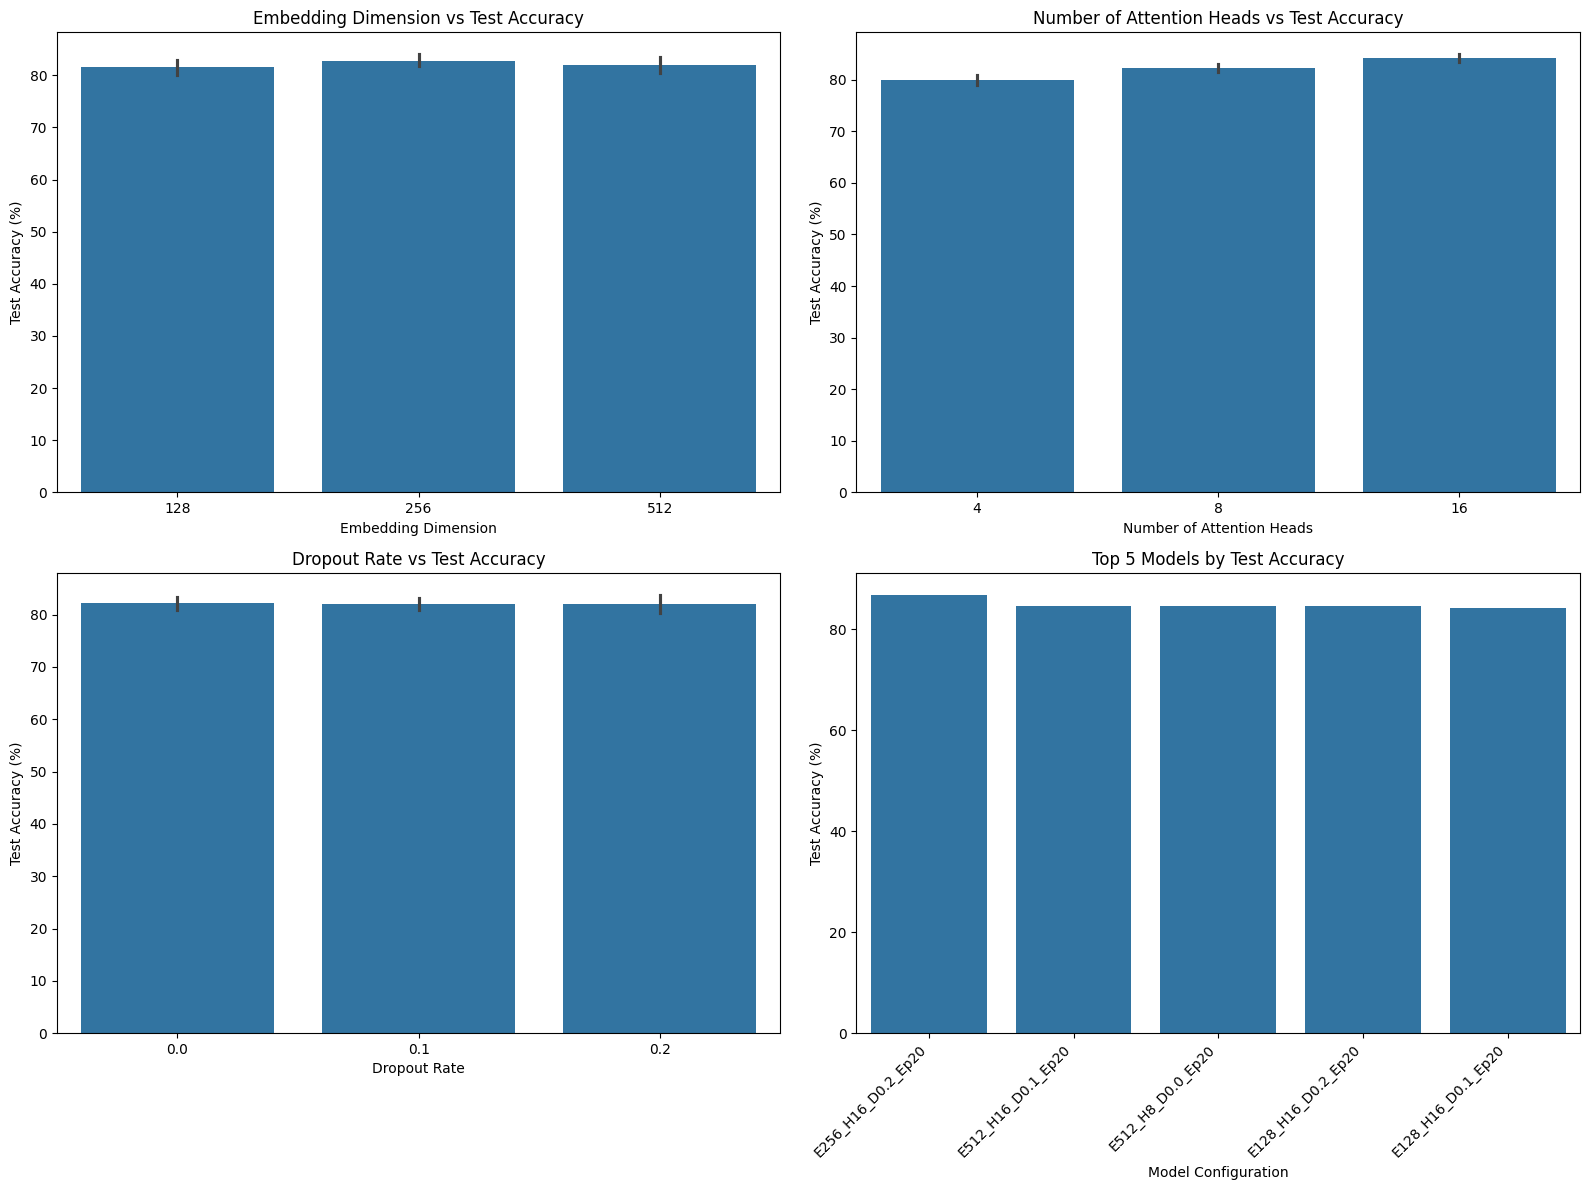

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1/20
Train loss: 1.71257 | Train accuracy: 48.94%


  5%|▌         | 1/20 [00:05<01:51,  5.89s/it]

Test loss: 1.23974 | Test accuracy: 64.30%

Epoch 2/20
Train loss: 0.88504 | Train accuracy: 73.89%


 10%|█         | 2/20 [00:11<01:44,  5.81s/it]

Test loss: 0.90295 | Test accuracy: 74.65%

Epoch 3/20
Train loss: 0.73161 | Train accuracy: 78.35%


 15%|█▌        | 3/20 [00:17<01:37,  5.73s/it]

Test loss: 0.85186 | Test accuracy: 73.71%

Epoch 4/20
Train loss: 0.65755 | Train accuracy: 81.04%


 20%|██        | 4/20 [00:22<01:30,  5.68s/it]

Test loss: 0.87719 | Test accuracy: 75.96%

Epoch 5/20
Train loss: 0.62677 | Train accuracy: 81.86%


 25%|██▌       | 5/20 [00:28<01:24,  5.66s/it]

Test loss: 0.84925 | Test accuracy: 76.10%

Epoch 6/20
Train loss: 0.58990 | Train accuracy: 82.84%


 30%|███       | 6/20 [00:34<01:19,  5.65s/it]

Test loss: 0.80637 | Test accuracy: 77.74%

Epoch 7/20
Train loss: 0.55516 | Train accuracy: 83.76%


 35%|███▌      | 7/20 [00:39<01:13,  5.65s/it]

Test loss: 0.67510 | Test accuracy: 81.00%

Epoch 8/20
Train loss: 0.52094 | Train accuracy: 84.47%


 40%|████      | 8/20 [00:45<01:07,  5.65s/it]

Test loss: 0.70738 | Test accuracy: 80.62%

Epoch 9/20
Train loss: 0.49988 | Train accuracy: 84.93%


 45%|████▌     | 9/20 [00:51<01:02,  5.66s/it]

Test loss: 0.64561 | Test accuracy: 82.16%

Epoch 10/20
Train loss: 0.47933 | Train accuracy: 85.87%


 50%|█████     | 10/20 [00:56<00:57,  5.71s/it]

Test loss: 0.64672 | Test accuracy: 82.13%

Epoch 11/20
Train loss: 0.46014 | Train accuracy: 86.34%


 55%|█████▌    | 11/20 [01:02<00:51,  5.70s/it]

Test loss: 0.70126 | Test accuracy: 82.43%

Epoch 12/20
Train loss: 0.44500 | Train accuracy: 86.26%


 60%|██████    | 12/20 [01:08<00:45,  5.70s/it]

Test loss: 0.70709 | Test accuracy: 81.06%

Epoch 13/20
Train loss: 0.43532 | Train accuracy: 86.79%


 65%|██████▌   | 13/20 [01:14<00:40,  5.74s/it]

Test loss: 0.69640 | Test accuracy: 81.73%

Epoch 14/20
Train loss: 0.44647 | Train accuracy: 86.73%


 70%|███████   | 14/20 [01:19<00:34,  5.72s/it]

Test loss: 0.62661 | Test accuracy: 83.02%

Epoch 15/20
Train loss: 0.40654 | Train accuracy: 87.65%


 75%|███████▌  | 15/20 [01:25<00:28,  5.70s/it]

Test loss: 0.57779 | Test accuracy: 85.17%

Epoch 16/20
Train loss: 0.39741 | Train accuracy: 87.60%


 80%|████████  | 16/20 [01:31<00:22,  5.68s/it]

Test loss: 0.71307 | Test accuracy: 81.50%

Epoch 17/20
Train loss: 0.44341 | Train accuracy: 86.88%


 85%|████████▌ | 17/20 [01:36<00:16,  5.66s/it]

Test loss: 0.64114 | Test accuracy: 83.06%

Epoch 18/20
Train loss: 0.39547 | Train accuracy: 87.74%


 90%|█████████ | 18/20 [01:42<00:11,  5.65s/it]

Test loss: 0.66718 | Test accuracy: 82.09%

Epoch 19/20
Train loss: 0.38496 | Train accuracy: 88.06%


 95%|█████████▌| 19/20 [01:48<00:05,  5.67s/it]

Test loss: 0.59124 | Test accuracy: 84.85%

Epoch 20/20
Train loss: 0.36105 | Train accuracy: 88.78%


100%|██████████| 20/20 [01:53<00:00,  5.69s/it]

Test loss: 0.58061 | Test accuracy: 84.93%


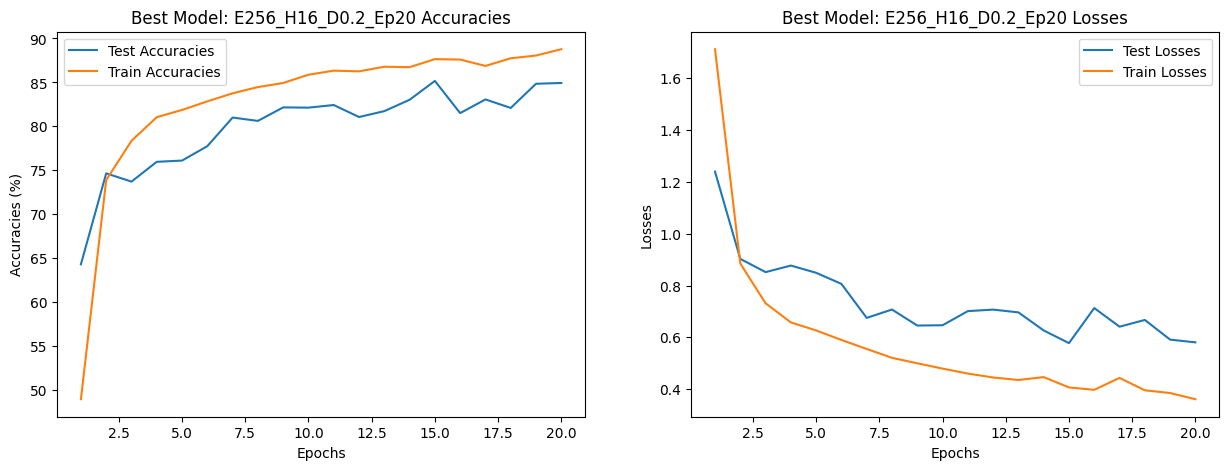

In [ ]:
def grid_search_attention_model(
    train_dataloader, 
    test_dataloader, 
    num_classes,
    device,
    embed_dims=[64, 128, 256, 512],
    num_heads_list=[4, 8, 16],
    p_drops=[0.0, 0.1, 0.2],
    epochs_list=[20],
    save_best=True,
    results_dir="grid_search_results"
):
    """
    Perform grid search for MultiHeadClassifier with pandas DataFrame tracking.
    Results are sorted by test accuracy.
    """
    
    print("Starting grid search for MultiHeadClassifier...")
    
    # Create directory for results if it doesn't exist
    if save_best and not os.path.exists(results_dir):
        os.makedirs(results_dir)
    
    # Generate all parameter combinations
    param_combinations = list(itertools.product(embed_dims, num_heads_list, p_drops, epochs_list))
    
    # Filter out invalid combinations (embed_dim must be divisible by num_heads)
    valid_combinations = [(ed, nh, pd, ep) for ed, nh, pd, ep in param_combinations if ed % nh == 0]
    
    print(f"Total valid parameter combinations: {len(valid_combinations)}")
    
    # Initialize results DataFrame
    results_df = pd.DataFrame(columns=[
        'embed_dim', 'num_heads', 'p_drop', 'epochs',
        'train_acc', 'test_acc', 'train_loss', 'test_loss', 
        'time_seconds', 'model_name'
    ])
    
    best_test_acc = 0
    best_model = None
    
    # Loop through combinations
    for i, (embed_dim, num_heads, p_drop, epochs) in enumerate(tqdm(valid_combinations, desc="Grid Search Progress")):
        # Create model name
        model_name = f"E{embed_dim}_H{num_heads}_D{p_drop}_Ep{epochs}"
        
        print(f"\n[{i+1}/{len(valid_combinations)}] Testing: {model_name}")
        
        # Initialize model
        model = MultiHeadClassifier(
            num_classes=num_classes,
            embed_dim=embed_dim,
            num_heads=num_heads,
            p_drop=p_drop
        ).to(device)
        
        # Train and time the model
        start_time = time.time()
        train_accs, test_accs, train_losses, test_losses = train_model(model, epochs,verbose=False)
        training_time = time.time() - start_time
        
        # Get final metrics
        final_train_acc = train_accs[-1]
        final_test_acc = test_accs[-1]
        final_train_loss = train_losses[-1]
        final_test_loss = test_losses[-1]
        
        # Add results to DataFrame
        new_row = pd.DataFrame([{
            'embed_dim': embed_dim,
            'num_heads': num_heads,
            'p_drop': p_drop,
            'epochs': epochs,
            'train_acc': final_train_acc,
            'test_acc': final_test_acc,
            'train_loss': final_train_loss,
            'test_loss': final_test_loss,
            'time_seconds': training_time,
            'model_name': model_name
        }])
        
        results_df = pd.concat([results_df, new_row], ignore_index=True)
        
        # Save intermediate results
        if save_best:
            results_df.to_csv(f"{results_dir}/grid_search_results.csv", index=False)
        
        # Check if this is the best model
        if final_test_acc > best_test_acc:
            best_test_acc = final_test_acc
            best_model = copy.deepcopy(model)
            
            # Save best model
            if save_best:
                torch.save(model.state_dict(), f"{results_dir}/best_model.pt")
                
        # Print summary
        print(f"Results: Train Acc: {final_train_acc:.2f}%, Test Acc: {final_test_acc:.2f}%")
        print(f"Time: {timedelta(seconds=int(training_time))}")
        
        # Sort and save updated results
        results_df = results_df.sort_values(by='test_acc', ascending=False).reset_index(drop=True)
        if save_best:
            results_df.to_csv(f"{results_dir}/grid_search_results_sorted.csv", index=False)
    
    # Final summary
    print("\n" + "="*50)
    print("Grid Search Complete!")
    print("="*50)
    
    # Display top 5 models
    print("\nTop 5 Models by Test Accuracy:")
    display(results_df.head(5))
    
    # Visualize results
    plot_grid_search_results(results_df)
    
    return results_df, best_model

def plot_grid_search_results(results_df):
    """Plot grid search results from DataFrame"""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(15, 10))
    
    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Embed Dim vs Test Accuracy
    sns.barplot(x='embed_dim', y='test_acc', data=results_df, ax=axs[0, 0], 
                order=sorted(results_df['embed_dim'].unique()))
    axs[0, 0].set_title('Embedding Dimension vs Test Accuracy')
    axs[0, 0].set_xlabel('Embedding Dimension')
    axs[0, 0].set_ylabel('Test Accuracy (%)')
    
    # Plot 2: Num Heads vs Test Accuracy
    sns.barplot(x='num_heads', y='test_acc', data=results_df, ax=axs[0, 1],
                order=sorted(results_df['num_heads'].unique()))
    axs[0, 1].set_title('Number of Attention Heads vs Test Accuracy')
    axs[0, 1].set_xlabel('Number of Attention Heads')
    axs[0, 1].set_ylabel('Test Accuracy (%)')
    
    # Plot 3: Dropout vs Test Accuracy
    sns.barplot(x='p_drop', y='test_acc', data=results_df, ax=axs[1, 0],
                order=sorted(results_df['p_drop'].unique()))
    axs[1, 0].set_title('Dropout Rate vs Test Accuracy')
    axs[1, 0].set_xlabel('Dropout Rate')
    axs[1, 0].set_ylabel('Test Accuracy (%)')
    
    # Plot 4: Top 5 Models
    top5 = results_df.head(5)
    sns.barplot(x='model_name', y='test_acc', data=top5, ax=axs[1, 1])
    axs[1, 1].set_title('Top 5 Models by Test Accuracy')
    axs[1, 1].set_xlabel('Model Configuration')
    axs[1, 1].set_ylabel('Test Accuracy (%)')
    axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('grid_search_results.png', dpi=300, bbox_inches='tight')
    plt.show()

embed_dims=[128, 256, 512]
num_heads_list=[4, 8, 16]
p_drops=[0.0, 0.1, 0.2]
epochs_list=[20]
# embed_dims = [128]
# num_heads_list = [2, 4]
# p_drops = [0.1]
# epochs_list = [5]

# Run grid search
results_df, best_model = grid_search_attention_model(
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    num_classes=NUM_CLASSES,
    device=device,
    embed_dims=embed_dims,
    num_heads_list=num_heads_list,
    p_drops=p_drops,
    epochs_list=epochs_list
)

# # Train best model for more epochs if desired
# print("\nTraining best model for more epochs...")
best_config = results_df.iloc[0]

final_model = MultiHeadClassifier(
    num_classes=NUM_CLASSES,
    embed_dim=int(best_config['embed_dim']),
    num_heads=int(best_config['num_heads']),
    p_drop=float(best_config['p_drop']),
).to(device)

train_accs, test_accs, train_losses, test_losses = train_model(final_model, epochs=best_config['epochs'],verbose=False)

# Plot results
plot_acc_losses(
    model_name=f"Best Model: {best_config['model_name']}",
    train_accs=train_accs,
    test_accs=test_accs,
    train_losses=train_losses,
    test_losses=test_losses,
    epochs=best_config['epochs']
)